# Open-set Wafer Map Triage (WM-811K)

- **MVP-1(완료)**: Known 분류 + OOD(Unknown 탐지, MSP/Energy) 평가  
- **MVP-2(진행중)**: 트리아지(UMAP 시각화 + Top-K 유사사례 검색)

> 핵심: Unknown을 “Unknown”으로 거부(reject)하고, 이후 판단을 돕는 트리아지 워크플로우

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0. 환경 설정
- Google Drive 마운트, 경로/시드 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

## 1. 데이터 로드 및 확인

In [ ]:
import pandas as pd

df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/data/LSWMD.pkl")
print(df.shape)
print(df["failureType"].head())      # 보통 list 형태거나 빈 list
print(df["trianTestLabel"].head())   # 기존 train/test 표기가 있을 수 있음(우리는 재분할 권장)

### 1.1 데이터 구조 확인

In [ ]:
print(df.columns)
print(df[["waferMap","failureType","trianTestLabel"]].head(3))

# waferMap 한 개의 형태 확인
wm0 = df["waferMap"].iloc[0]
print(type(wm0), getattr(wm0, "shape", None))

### 1.2 라벨 전처리 (failureType → label)

In [ ]:
import numpy as np

def get_label(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return str(x[0][0]) if len(x) > 0 else None
    if isinstance(x, str) and x.strip() != "":
        return x
    return None

df["label"] = df["failureType"].apply(get_label)

print(df["label"].value_counts(dropna=False).head(15))
print("labeled count:", df["label"].notna().sum())

In [ ]:
print(type(df.iloc[0]["label"]))

## 2. Open-set 평가 설계 (클래스 홀드아웃)
- Donut과 Scratch를 Unknown(홀드아웃)으로 설정

In [ ]:
UNKNOWN_CLASSES = ["Donut", "Scratch"]

labeled = df[df["label"].notna()].copy()
known_df = labeled[~labeled["label"].isin(UNKNOWN_CLASSES)].copy()
unknown_df = labeled[labeled["label"].isin(UNKNOWN_CLASSES)].copy()

print("labeled:", len(labeled))
print("known:", len(known_df))
print("unknown:", len(unknown_df))
print("known classes:", sorted(known_df["label"].unique()))
print("unknown classes:", sorted(unknown_df["label"].unique()))

## 3. 클래스 이해 및 시각화

### 3.1 클래스 정의 + 컬러 의미


- **Center**: 웨이퍼 **중심(가운데)**에 불량이 몰려 있는 패턴 (가운데 뭉침)
- **Donut**: 중심은 비교적 깨끗하고, 그 주변에 **동심원(도넛 링)**처럼 불량이 분포 (원형 띠)
- **Edge-Loc (Edge-Local)**: 웨이퍼 **가장자리의 특정 구간**에만 불량이 몰린 패턴 (테두리 한쪽만)
- **Edge-Ring**: 웨이퍼 **테두리 전체를 따라 고리(링)**처럼 불량이 나타나는 패턴 (둘레 전체 띠)
- **Loc (Local)**: 웨이퍼 내부에서 **중심/테두리가 아닌 임의 위치**에 불량이 뭉친 패턴 (안쪽 어딘가 덩어리)
- **Random**: 웨이퍼 전체에 불량이 **듬성듬성, 비교적 고르게 흩어진** 패턴 (여기저기 점)
- **Scratch**: **직선/곡선 형태로 길게 이어진** 불량 패턴 (긁힌 자국처럼 선/호)
- **Near-full**: 웨이퍼 **거의 전체가 불량으로 채워진** 패턴 (대부분 불량)
- **none**: 뚜렷한 결함 패턴이 없거나 결함이 거의 없는 상태 (패턴 없음)
---
- 보라(가장 어두운 색) = 작은 값 (보통 0) → 웨이퍼 바깥/배경
- 파랑(중간 값) = 중간 값 (보통 1) → 정상 die (pass)
- 노랑(가장 밝은 색) = 큰 값 (보통 2) → 불량 die (fail)

### 3.2 클래스별 대표 1장 그리드로 보기

In [ ]:
import matplotlib.pyplot as plt

labels = sorted(labeled["label"].unique())
n = len(labels)

cols = 4
rows = (n + cols - 1) // cols

plt.figure(figsize=(4*cols, 4*rows))
for i, lab in enumerate(labels):
    wm = labeled[labeled["label"] == lab]["waferMap"].iloc[0]  # 첫 샘플
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(wm, interpolation="nearest")
    ax.set_title(lab)
    ax.axis("off")
plt.tight_layout()
plt.show()

### 3.3 특정 Failure Type 랜덤 샘플 보기

In [ ]:
import matplotlib.pyplot as plt

def show_samples(label, n=8, seed=42):
    sub = labeled[labeled["label"] == label]
    if len(sub) == 0:
        print("No samples for:", label)
        return
    sub = sub.sample(n=min(n, len(sub)), random_state=seed)

    cols = 4
    rows = (len(sub) + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i, wm in enumerate(sub["waferMap"].tolist()):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(wm, interpolation="nearest")
        ax.axis("off")
    plt.suptitle(f"{label} (n={len(sub)})", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# 예시
for label in ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full", "none"]:
    show_samples(label, n=8, seed=0)

## 4. 데이터 분할 (train/val/test_known/test_unknown)

- train = 70%
- val = 15%
- test_known = 15%
- test_unknown = unknown_df 전부

이 비율은 머신러닝에서 아주 흔한 기본값

- train을 충분히 크게 가져가야 학습이 잘 되고
- val/test도 너무 작으면 지표가 흔들리니까 적당히 확보하는 균형

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    known_df, test_size=0.3, random_state=42, stratify=known_df["label"] # stratify는 각 split마다 라벨 비율이 원래 데이터랑 비슷하게 유지되도록 나눠주는 옵션
)
val_df, test_known_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

test_unknown_df = unknown_df.copy()

print("train:", len(train_df), "val:", len(val_df),
      "test_known:", len(test_known_df), "test_unknown:", len(test_unknown_df))

## 5. Dataset/DataLoader 구성 (전처리/증강)


*   waferMap을 64×64로 resize
*   1채널을 3채널로 복제해서 ResNet에 넣기 (가장 쉬운 방식)
*   회전/반전 증강은 train에만

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

known_classes = sorted(train_df["label"].unique())
class_to_idx = {c:i for i,c in enumerate(known_classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
print(class_to_idx)

class WaferMapDataset(Dataset):
    def __init__(self, df, class_to_idx=None, is_train=False, resize=64):
        self.df = df.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.is_train = is_train
        self.resize = resize

    def __len__(self):
        return len(self.df)

    def _augment(self, x):
        # x: (1,H,W)
        if torch.rand(1).item() < 0.5:
            x = torch.flip(x, dims=[2])  # 좌우
        if torch.rand(1).item() < 0.5:
            x = torch.flip(x, dims=[1])  # 상하
        k = int(torch.randint(0, 4, (1,)).item())
        x = torch.rot90(x, k, dims=[1,2])
        return x

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wm = row["waferMap"]  # numpy 2D
        x = torch.tensor(wm, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

        # 0/1/2 형태면 0~1로 스케일 (선택)
        mx = x.max()
        x = x / (mx if mx > 0 else 1.0)

        # resize
        x = F.interpolate(x.unsqueeze(0), size=(self.resize, self.resize), mode="nearest").squeeze(0)

        if self.is_train:
            x = self._augment(x)

        # ResNet 입력 맞추기: 3채널
        x = x.repeat(3, 1, 1)  # (3,resize,resize)

        if self.class_to_idx is None:
            return x

        y = self.class_to_idx[row["label"]]
        return x, y

train_loader = DataLoader(WaferMapDataset(train_df, class_to_idx, True, 64),
                          batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(WaferMapDataset(val_df, class_to_idx, False, 64),
                        batch_size=256, shuffle=False, num_workers=2)
test_known_loader = DataLoader(WaferMapDataset(test_known_df, class_to_idx, False, 64),
                               batch_size=256, shuffle=False, num_workers=2)
test_unknown_loader = DataLoader(
    WaferMapDataset(test_unknown_df, class_to_idx=None, is_train=False, resize=64),
    batch_size=256, shuffle=False, num_workers=2
)

## 6. Known 분류기 학습 (ResNet18 베이스라인)

In [ ]:
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(known_classes))
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, correct, total = 0, 0, 0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = torch.tensor(y).to(device)

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss/total, correct/total

for epoch in range(1, 6):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

## 7. Known 성능 평가 (macro-F1 중심)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report

@torch.no_grad()
def predict_known(loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy()
        ys.append(np.array(y))
        ps.append(pred)
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return y_true, y_pred

y_true, y_pred = predict_known(test_known_loader)
print("macro-F1:", f1_score(y_true, y_pred, average="macro"))
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(known_classes))]))

## 8. OOD(Unknown 탐지) 평가: MSP vs Energy

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

@torch.no_grad()
def collect_scores(loader, known=True, T=1.0):
    model.eval()
    msp_list, energy_list = [], []
    for batch in loader:
        x = batch[0] if known else batch
        x = x.to(device)

        logits = model(x) / T
        prob = torch.softmax(logits, dim=1)
        msp = prob.max(dim=1).values                   # 높을수록 known
        energy = -T * torch.logsumexp(logits, dim=1)   # 보통 -energy가 높을수록 known로 사용

        msp_list.append(msp.cpu().numpy())
        energy_list.append(energy.cpu().numpy())

    return np.concatenate(msp_list), np.concatenate(energy_list)

msp_k, en_k = collect_scores(test_known_loader, known=True)
msp_u, en_u = collect_scores(test_unknown_loader, known=False)

y = np.concatenate([np.ones_like(msp_k), np.zeros_like(msp_u)])  # known=1, unknown=0

score_msp = np.concatenate([msp_k, msp_u])
score_energy = np.concatenate([-en_k, -en_u])  # -energy를 known 점수로

print("AUROC MSP   :", roc_auc_score(y, score_msp))
print("AUPR  MSP   :", average_precision_score(y, score_msp))
print("AUROC Energy:", roc_auc_score(y, score_energy))
print("AUPR  Energy:", average_precision_score(y, score_energy))

## 9. 체크포인트 로드


저장된 `state_dict`를 불러와 새로운 모델 인스턴스에 로드합니다. 이때, 모델의 아키텍처는 저장할 때와 동일하게 정의되어 있어야 합니다.

In [2]:
import os, json
from datetime import datetime
import torch
import torchvision.models as models
import torch.nn as nn

CKPT_DIR = "/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

def _safe(s: str) -> str:
    return (
        str(s).replace(" ", "")
        .replace("/", "-").replace("\\", "-")
        .replace(",", "-").replace("[", "").replace("]", "")
        .replace("'", "").replace('"', "")
    )

def _get(name, default=None):
    # 노트북 전역 변수에서 자동으로 가져오기
    return globals().get(name, default)

def save_mvp_checkpoint(
    model,
    class_to_idx,
    unknown_classes,
    resize=64,
    arch="resnet18",
    optimizer=None,
    ckpt_dir=CKPT_DIR,
    extra_cfg=None,
):
    """
    ✅ 자동 저장:
    - 노트북에 val_macro_f1 / auroc_msp / auroc_energy / epochs 등의 변수가 있으면 자동으로 메타+파일명에 반영
    - 없으면 없는대로 저장 (MVP 중간 저장에도 사용 가능)
    """
    os.makedirs(ckpt_dir, exist_ok=True)

    # 자동으로 메트릭/설정 값 끌어오기(있으면 쓰고, 없으면 None)
    epochs = _get("epochs_run", None) or _get("EPOCHS", None) or _get("epochs", None)
    val_macro_f1 = _get("val_macro_f1", None)
    auroc_msp = _get("auroc_msp", None)
    auroc_energy = _get("auroc_energy", None)
    holdout = "-".join([_safe(x) for x in (unknown_classes or [])]) or "none"
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")

    # 파일명 구성(있는 정보만 추가)
    parts = [ts, _safe(arch), f"r{int(resize)}", f"holdout-{holdout}"]
    if epochs is not None:
        parts.append(f"ep{int(epochs):02d}")
    if val_macro_f1 is not None:
        parts.append(f"valF1-{float(val_macro_f1):.3f}")
    if auroc_msp is not None:
        parts.append(f"aurocMSP-{float(auroc_msp):.3f}")
    if auroc_energy is not None:
        parts.append(f"aurocEn-{float(auroc_energy):.3f}")

    run_name = "_".join(parts)
    ckpt_path = os.path.join(ckpt_dir, run_name + ".pt")

    # 체크포인트 내용
    ckpt = {
        "arch": arch,
        "resize": int(resize),
        "unknown_classes": list(unknown_classes) if unknown_classes is not None else None,
        "class_to_idx": dict(class_to_idx),
        "model_state_dict": model.state_dict(),
        "metrics": {
            "val_macro_f1": val_macro_f1,
            "auroc_msp": auroc_msp,
            "auroc_energy": auroc_energy,
        },
        "cfg": extra_cfg or {},
        "saved_at": datetime.now().isoformat(),
    }
    if optimizer is not None:
        ckpt["optimizer_state_dict"] = optimizer.state_dict()

    torch.save(ckpt, ckpt_path)

    # 사람이 보기 좋은 메타 json도 같이 저장(선택이지만 추천)
    meta_path = ckpt_path.replace(".pt", ".json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(
            {k: ckpt[k] for k in ["arch", "resize", "unknown_classes", "metrics", "cfg", "saved_at"]},
            f, ensure_ascii=False, indent=2
        )

    print("✅ Saved:", ckpt_path)
    print("📝 Meta :", meta_path)
    return ckpt_path

def load_mvp_checkpoint(path, device="cpu"):
    ckpt = torch.load(path, map_location=device)

    class_to_idx = ckpt["class_to_idx"]
    known_classes = [None] * len(class_to_idx)
    for cls, idx in class_to_idx.items():
        known_classes[idx] = cls

    arch = ckpt.get("arch", "resnet18")
    if arch == "resnet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, len(known_classes))
    else:
        raise ValueError(f"Unsupported arch: {arch}")

    model.load_state_dict(ckpt["model_state_dict"])
    model = model.to(device).eval()

    print("✅ Loaded:", path)
    print(" - arch:", arch, "| resize:", ckpt.get("resize"))
    print(" - unknown_classes:", ckpt.get("unknown_classes"))
    print(" - metrics:", ckpt.get("metrics", {}))
    return model, ckpt, known_classes, class_to_idx

In [ ]:
ckpt_path = save_mvp_checkpoint(model, class_to_idx, UNKNOWN_CLASSES, resize=64, arch="resnet18", optimizer=None)

In [3]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# =========================
# 0) 기본 설정
# =========================
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/data/LSWMD.pkl"

CKPT_DIR  = "/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/checkpoints"
# ✅ 가장 최근 체크포인트 자동 선택(원하면 CKPT_PATH를 직접 지정해도 됨)
if "CKPT_PATH" not in globals() or CKPT_PATH is None:
    pts = sorted([os.path.join(CKPT_DIR, f) for f in os.listdir(CKPT_DIR) if f.endswith(".pt")])
    assert len(pts) > 0, f"No .pt found in {CKPT_DIR}"
    CKPT_PATH = pts[-1]

device = "cuda" if "torch" in globals() and torch.cuda.is_available() else "cpu"
RANDOM_STATE = 42

print("Using CKPT_PATH:", CKPT_PATH)
print("Using DATA_PATH:", DATA_PATH)
print("Device:", device)

# =========================
# 1) 체크포인트 로드
# =========================
loaded_model, ckpt, known_classes_loaded, class_to_idx_loaded = load_mvp_checkpoint(CKPT_PATH, device=device)

# 노트북 공통 변수명으로 맞추기
model = loaded_model
class_to_idx = class_to_idx_loaded

# ckpt에 들어있는 설정(없으면 기본값)
UNKNOWN_CLASSES = ckpt.get("unknown_classes", None) or ["Donut", "Scratch"]
RESIZE = int(ckpt.get("resize", 64))

# ⚠️ 이후 코드에서 헷갈리지 않게:
known_classes_model = known_classes_loaded     # 모델 출력 매핑 기준(고정)
print("Holdout(UNKNOWN_CLASSES):", UNKNOWN_CLASSES)
print("RESIZE:", RESIZE)
print("known_classes_model:", known_classes_model)

# =========================
# 2) 데이터 로드 & label 생성(핵심 수정 포인트)
#    - failureType이 list가 아니라 np.ndarray인 경우가 많아서 그것도 처리해야 함
# =========================
df = pd.read_pickle(DATA_PATH)

def _to_label(x):
    # None / NaN
    if x is None:
        return None
    if isinstance(x, float) and np.isnan(x):
        return None

    # ✅ 핵심: numpy.ndarray / list / tuple 안에 또 ndarray가 있는 경우가 있어서
    # "스칼라 문자열"이 나올 때까지 첫 원소를 계속 벗김
    for _ in range(5):
        if isinstance(x, np.ndarray):
            if x.size == 0:
                return None
            x = x.ravel()[0]
            continue
        if isinstance(x, (list, tuple)):
            if len(x) == 0:
                return None
            x = x[0]
            continue
        break

    # numpy scalar → python scalar
    if isinstance(x, np.generic):
        x = x.item()

    # 최종 문자열 정리
    if isinstance(x, str):
        x = x.strip()
        return x if x != "" else None

    # 혹시라도 여기까지 왔는데 문자열이 아니면 안전하게 문자열화(거의 없음)
    return str(x)

df["label"] = df["failureType"].apply(_to_label)

print("\n[Debug] failureType type top:")
print(df["failureType"].apply(type).value_counts().head(5))
print("\n[Debug] label value top:")
print(df["label"].value_counts(dropna=False).head(10))

# =========================
# 3) Open-set 구성(holdout) + split (10.2에서 필요한 변수 생성)
# =========================
labeled = df[df["label"].notna()].copy()

# ✅ 모델이 학습한 known 클래스(ckpt의 class_to_idx)만 known 후보로 사용 (안전)
KNOWN_SET = set(class_to_idx.keys())

known_all = labeled[labeled["label"].isin(KNOWN_SET)].copy()
known_df = known_all[~known_all["label"].isin(UNKNOWN_CLASSES)].copy()
unknown_df = labeled[labeled["label"].isin(UNKNOWN_CLASSES)].copy()

print("\nCounts:")
print(" - labeled   :", len(labeled))
print(" - known_all :", len(known_all))
print(" - known_df  :", len(known_df))
print(" - unknown_df:", len(unknown_df))

# known_df가 0이면 여기서 멈추고 원인 확인
if len(known_df) == 0:
    raise ValueError(
        "known_df가 0입니다. label 생성/필터링 문제일 가능성이 큽니다.\n"
        "위 Debug 출력(label value top)에서 실제 라벨 문자열을 확인하세요."
    )

# stratify가 가끔 실패(특히 매우 작은 클래스)할 수 있어 fallback 포함
try:
    train_df, temp_df = train_test_split(
        known_df, test_size=0.3, random_state=RANDOM_STATE, stratify=known_df["label"]
    )
    val_df, test_known_df = train_test_split(
        temp_df, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_df["label"]
    )
except ValueError as e:
    print("\n[Warn] Stratified split failed. Falling back to non-stratified split.")
    print("Reason:", e)
    train_df, temp_df = train_test_split(
        known_df, test_size=0.3, random_state=RANDOM_STATE, shuffle=True
    )
    val_df, test_known_df = train_test_split(
        temp_df, test_size=0.5, random_state=RANDOM_STATE, shuffle=True
    )

test_unknown_df = unknown_df.reset_index(drop=True)

# ✅ 10.2에서 쓰는 known_classes는 데이터 기준으로(비어있지 않게) 다시 세팅
known_classes = sorted(train_df["label"].unique())

print("\nSplit:")
print(" - train       :", len(train_df))
print(" - val         :", len(val_df))
print(" - test_known  :", len(test_known_df))
print(" - test_unknown:", len(test_unknown_df))

known_classes = sorted(train_df["label"].unique())
class_to_idx = {c:i for i,c in enumerate(known_classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
print(class_to_idx)

class WaferMapDataset(Dataset):
    def __init__(self, df, class_to_idx=None, is_train=False, resize=64):
        self.df = df.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.is_train = is_train
        self.resize = resize

    def __len__(self):
        return len(self.df)

    def _augment(self, x):
        # x: (1,H,W)
        if torch.rand(1).item() < 0.5:
            x = torch.flip(x, dims=[2])  # 좌우
        if torch.rand(1).item() < 0.5:
            x = torch.flip(x, dims=[1])  # 상하
        k = int(torch.randint(0, 4, (1,)).item())
        x = torch.rot90(x, k, dims=[1,2])
        return x

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wm = row["waferMap"]  # numpy 2D
        x = torch.tensor(wm, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

        # 0/1/2 형태면 0~1로 스케일 (선택)
        mx = x.max()
        x = x / (mx if mx > 0 else 1.0)

        # resize
        x = F.interpolate(x.unsqueeze(0), size=(self.resize, self.resize), mode="nearest").squeeze(0)

        if self.is_train:
            x = self._augment(x)

        # ResNet 입력 맞추기: 3채널
        x = x.repeat(3, 1, 1)  # (3,resize,resize)

        if self.class_to_idx is None:
            return x

        y = self.class_to_idx[row["label"]]
        return x, y

train_loader = DataLoader(WaferMapDataset(train_df, class_to_idx, True, 64),
                          batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(WaferMapDataset(val_df, class_to_idx, False, 64),
                        batch_size=256, shuffle=False, num_workers=2)
test_known_loader = DataLoader(WaferMapDataset(test_known_df, class_to_idx, False, 64),
                               batch_size=256, shuffle=False, num_workers=2)
test_unknown_loader = DataLoader(
    WaferMapDataset(test_unknown_df, class_to_idx=None, is_train=False, resize=64),
    batch_size=256, shuffle=False, num_workers=2
)

print("\nREADY ✅")
print(" - known_classes(for 10.2):", known_classes)
print(" - known_classes_model(ckpt):", known_classes_model)
print(" - resize:", RESIZE, "| holdout:", UNKNOWN_CLASSES)


Using CKPT_PATH: /content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/checkpoints/20251231-152621_resnet18_r64_holdout-Donut-Scratch_ep05_valF1-0.872_aurocMSP-0.862_aurocEn-0.852.pt
Using DATA_PATH: /content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/data/LSWMD.pkl
Device: cuda
✅ Loaded: /content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/checkpoints/20251231-152621_resnet18_r64_holdout-Donut-Scratch_ep05_valF1-0.872_aurocMSP-0.862_aurocEn-0.852.pt
 - arch: resnet18 | resize: 64
 - unknown_classes: ['Donut', 'Scratch']
 - metrics: {'val_macro_f1': 0.8715149558807184, 'auroc_msp': 0.8619361677159039, 'auroc_energy': 0.8524458064385632}
Holdout(UNKNOWN_CLASSES): ['Donut', 'Scratch']
RESIZE: 64
known_classes_model: ['Center', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'none']

[Debug] failureType type top:
failureType
<class 'numpy.ndarray'>    811457
Name: count, dtyp

## 10. 트리아지(MVP-2): 임베딩 기반 유사사례/시각화
### 10.1 트리아지용 Dataset (이미지 + 라벨 + row index)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np

class WaferMapDatasetWithIdx(Dataset):
    def __init__(self, df, class_to_idx=None, is_train=False, resize=64):
        self.df = df.reset_index(drop=True).copy()
        self.class_to_idx = class_to_idx
        self.is_train = is_train
        self.resize = resize

    def __len__(self):
        return len(self.df)

    def _augment(self, x):
        if torch.rand(1).item() < 0.5:
            x = torch.flip(x, dims=[2])  # 좌우
        if torch.rand(1).item() < 0.5:
            x = torch.flip(x, dims=[1])  # 상하
        k = int(torch.randint(0, 4, (1,)).item())
        x = torch.rot90(x, k, dims=[1,2])
        return x

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wm = row["waferMap"]
        x = torch.tensor(wm, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

        mx = x.max()
        x = x / (mx if mx > 0 else 1.0)

        x = F.interpolate(x.unsqueeze(0), size=(self.resize, self.resize), mode="nearest").squeeze(0)

        if self.is_train:
            x = self._augment(x)

        x = x.repeat(3, 1, 1)  # (3,resize,resize)

        # 라벨이 없으면 x, idx만
        if self.class_to_idx is None:
            return x, idx

        y = self.class_to_idx[row["label"]]
        return x, y, idx

### 10.2 레퍼런스(known) 풀 샘플링

In [5]:
# ✅ 추천: reference에서는 none을 줄이거나 제외
MAX_PER_CLASS = 1500
MAX_NONE = 2000

ref_parts = []
for c in known_classes:
    sub = train_df[train_df["label"] == c]
    if c == "none":
        sub = sub.sample(n=min(len(sub), MAX_NONE), random_state=42)
    else:
        sub = sub.sample(n=min(len(sub), MAX_PER_CLASS), random_state=42)
    ref_parts.append(sub)

ref_df = pd.concat(ref_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)
print("ref_df size:", len(ref_df))
print(ref_df["label"].value_counts().head())

ref_df size: 8710
label
none         2000
Center       1500
Edge-Loc     1500
Loc          1500
Edge-Ring    1500
Name: count, dtype: int64


### 10.3 임베딩 추출 모델 (fc 직전 특징)

In [7]:
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# model은 너가 학습한 모델(또는 loaded_model) 사용
model = loaded_model if "loaded_model" in globals() else model
model = model.to(device).eval()

# fc 제거 → 임베딩 추출기
embed_model = nn.Sequential(*list(model.children())[:-1]).to(device).eval()

@torch.no_grad()
def collect_embeddings_ref(loader):
    embs, labels, idxs = [], [], []
    for x, y, idx in loader:
        x = x.to(device)
        e = embed_model(x).squeeze(-1).squeeze(-1)  # (N,512,1,1) -> (N,512)
        embs.append(e.cpu())
        labels.append(torch.tensor(y))
        idxs.append(torch.tensor(idx))
    return torch.cat(embs, 0).numpy(), torch.cat(labels, 0).numpy(), torch.cat(idxs, 0).numpy()

@torch.no_grad()
def collect_embeddings_unknown(loader):
    embs, idxs = [], []
    for x, idx in loader:
        x = x.to(device)
        e = embed_model(x).squeeze(-1).squeeze(-1)
        embs.append(e.cpu())
        idxs.append(torch.tensor(idx))
    return torch.cat(embs, 0).numpy(), torch.cat(idxs, 0).numpy()

### 10.4 임베딩 추출 (ref/unknown)

In [8]:
# reference(known)
ref_loader = DataLoader(
    WaferMapDatasetWithIdx(ref_df, class_to_idx=class_to_idx, is_train=False, resize=64),
    batch_size=256, shuffle=False, num_workers=2
)

# unknown(test_unknown_df)
unk_loader = DataLoader(
    WaferMapDatasetWithIdx(test_unknown_df, class_to_idx=None, is_train=False, resize=64),
    batch_size=256, shuffle=False, num_workers=2
)

ref_emb, ref_y, ref_local_idx = collect_embeddings_ref(ref_loader)
unk_emb, unk_local_idx = collect_embeddings_unknown(unk_loader)

print("ref_emb:", ref_emb.shape, "unk_emb:", unk_emb.shape)

/tmp/ipython-input-1116982506.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(y))
/tmp/ipython-input-1116982506.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idxs.append(torch.tensor(idx))
/tmp/ipython-input-1116982506.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idxs.append(torch.tensor(idx))


ref_emb: (8710, 512) unk_emb: (1748, 512)


### 10.5 Unknown → 유사사례 Top-K 검색 (코사인 유사도)

In [9]:
import numpy as np

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

ref_n = l2norm(ref_emb)
unk_n = l2norm(unk_emb)

# Top-K retrieval
K = 5
# (unk x ref) similarity가 커질 수 있으니 unk를 배치로 처리
def topk_retrieval(unk_n, ref_n, k=5, chunk=512):
    topk_idx_all, topk_sim_all = [], []
    ref_t = torch.tensor(ref_n, dtype=torch.float32)
    for i in range(0, len(unk_n), chunk):
        u = torch.tensor(unk_n[i:i+chunk], dtype=torch.float32)
        sim = u @ ref_t.T  # cosine similarity
        topk_sim, topk_idx = torch.topk(sim, k=k, dim=1)
        topk_idx_all.append(topk_idx.numpy())
        topk_sim_all.append(topk_sim.numpy())
    return np.vstack(topk_idx_all), np.vstack(topk_sim_all)

topk_idx, topk_sim = topk_retrieval(unk_n, ref_n, k=K, chunk=512)
print(topk_idx.shape, topk_sim.shape)  # (num_unknown, K)

(1748, 5) (1748, 5)


### 10.6 Top-K 결과 시각화 함수

In [ ]:
import matplotlib.pyplot as plt

def show_triage_case(unk_i, K=5):
    # unknown 샘플
    unk_row = test_unknown_df.iloc[int(unk_local_idx[unk_i])]
    unk_wm = unk_row["waferMap"]

    # ref 샘플들
    ref_indices = topk_idx[unk_i][:K]
    ref_sims = topk_sim[unk_i][:K]

    plt.figure(figsize=(3*(K+1), 3))
    # unknown
    plt.subplot(1, K+1, 1)
    plt.imshow(unk_wm)
    plt.title(f"UNKNOWN\n(true={unk_row['label']})")
    plt.axis("off")

    for j in range(K):
        rloc = int(ref_local_idx[ref_indices[j]])  # ref_df의 로컬 인덱스
        rrow = ref_df.iloc[rloc]
        plt.subplot(1, K+1, j+2)
        plt.imshow(rrow["waferMap"])
        plt.title(f"{rrow['label']}\ncos={ref_sims[j]:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 예시로 3개만 보기
for i in [0, 1, 2]:
    show_triage_case(i, K=5)

### 10.7 2D 시각화 (UMAP)

In [ ]:
!pip -q install umap-learn

import umap
import numpy as np
import matplotlib.pyplot as plt

# 시각화는 너무 많으면 느리니 샘플링
N_REF_VIS = min(5000, len(ref_emb))
N_UNK_VIS = min(2000, len(unk_emb))

rng = np.random.RandomState(42)
ref_vis_idx = rng.choice(len(ref_emb), size=N_REF_VIS, replace=False)
unk_vis_idx = rng.choice(len(unk_emb), size=N_UNK_VIS, replace=False)

X_vis = np.vstack([ref_emb[ref_vis_idx], unk_emb[unk_vis_idx]])
y_vis = np.concatenate([ref_y[ref_vis_idx], -1*np.ones(N_UNK_VIS, dtype=int)])  # unknown=-1

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
Z = reducer.fit_transform(X_vis)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=y_vis, s=6)  # 색은 클래스 id로 자동
plt.title("Embedding 2D (UMAP): known vs unknown")
plt.show()

In [ ]:
import numpy as np
print("known points:", np.sum(y_vis != -1))
print("unknown points:", np.sum(y_vis == -1))
print("unique labels (incl -1):", np.unique(y_vis)[:20])

In [ ]:
import matplotlib.pyplot as plt

known_mask = (y_vis != -1)
unk_mask = (y_vis == -1)

plt.figure(figsize=(8,6))
plt.scatter(Z[known_mask,0], Z[known_mask,1], s=6, alpha=0.25, label="known")
plt.scatter(Z[unk_mask,0],   Z[unk_mask,1],   s=8, alpha=0.9,  label="unknown")
plt.title("Embedding 2D (UMAP): known (gray) vs unknown (red)")
plt.legend()
plt.show()

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

Xn = l2norm(X_vis)  # 코사인에 맞게 정규화(권장)

reducer = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42)
Z = reducer.fit_transform(Xn)

known_mask = (y_vis != -1)
unk_mask = (y_vis == -1)

plt.figure(figsize=(8,6))
plt.scatter(Z[known_mask,0], Z[known_mask,1], s=6, alpha=0.25, color="gray", label="known")
plt.scatter(Z[unk_mask,0],   Z[unk_mask,1],   s=10, alpha=0.9,  color="red",  label="unknown")
plt.title("Embedding 2D (UMAP-cosine): known (gray) vs unknown (red)")
plt.legend()
plt.show()

### 10.8 Top-K 트리아지 데모

In [ ]:
import numpy as np
import torch

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

ref_n = l2norm(ref_emb).astype(np.float32)
unk_n = l2norm(unk_emb).astype(np.float32)

def topk_retrieval(unk_n, ref_n, k=5, chunk=512):
    topk_idx_all, topk_sim_all = [], []
    ref_t = torch.tensor(ref_n)  # (Nref, D)
    for i in range(0, len(unk_n), chunk):
        u = torch.tensor(unk_n[i:i+chunk])   # (chunk, D)
        sim = u @ ref_t.T                    # (chunk, Nref)
        topk_sim, topk_idx = torch.topk(sim, k=k, dim=1)
        topk_idx_all.append(topk_idx.numpy())
        topk_sim_all.append(topk_sim.numpy())
    return np.vstack(topk_idx_all), np.vstack(topk_sim_all)

K = 5
topk_idx, topk_sim = topk_retrieval(unk_n, ref_n, k=K, chunk=512)
print(topk_idx.shape, topk_sim.shape)  # (N_unknown, K)

### 10.9 트리아지 요약 한 줄 (발표용)

In [ ]:
from collections import Counter
import numpy as np

def triage_summary(unk_i, K=5):
    labels = [ref_df.iloc[j]["label"] for j in topk_idx[unk_i][:K]]
    cnt = Counter(labels)
    top_label, top_count = cnt.most_common(1)[0]
    purity = top_count / K
    uniq = len(cnt)

    if purity >= 0.8:
        msg = f"Top-{K} 중 {top_label} {top_count}/{K} → '{top_label}' 계열 가능성 높음"
    elif uniq >= 4:
        msg = f"Top-{K} 라벨 다양({dict(cnt)}) → 애매 케이스(추가 확인/재측정 권장)"
    else:
        msg = f"Top-{K} 혼재({dict(cnt)}) → 유사 패턴 후보 복수"
    return labels, msg

### 10.10 데모 화면 출력 (Unknown + Top-K)

In [ ]:
import matplotlib.pyplot as plt

def show_triage_case(unk_i, K=5):
    unk_row = test_unknown_df.iloc[unk_i]
    unk_wm = unk_row["waferMap"]

    labels, msg = triage_summary(unk_i, K)

    plt.figure(figsize=(3*(K+1), 3))
    plt.subplot(1, K+1, 1)
    plt.imshow(unk_wm)
    plt.title(f"UNKNOWN\n(true={unk_row['label']})")
    plt.axis("off")

    for j in range(K):
        rrow = ref_df.iloc[topk_idx[unk_i][j]]
        plt.subplot(1, K+1, j+2)
        plt.imshow(rrow["waferMap"])
        plt.title(f"{rrow['label']}\ncos={topk_sim[unk_i][j]:.3f}")
        plt.axis("off")

    plt.suptitle(msg, y=1.05, fontsize=12)
    plt.tight_layout()
    plt.show()

# 예시 3개 확인
for i in [0, 1, 2]:
    show_triage_case(i, K=5)

### 10.11 데모 결과 저장 (이미지/요약)

In [ ]:
import os
import matplotlib.pyplot as plt

OUT_DIR = "assets/triage"
os.makedirs(OUT_DIR, exist_ok=True)

def save_triage_case(unk_i, K=5):
    unk_row = test_unknown_df.iloc[unk_i]
    labels, msg = triage_summary(unk_i, K)

    plt.figure(figsize=(3*(K+1), 3))
    plt.subplot(1, K+1, 1)
    plt.imshow(unk_row["waferMap"])
    plt.title(f"UNKNOWN\n(true={unk_row['label']})")
    plt.axis("off")

    for j in range(K):
        rrow = ref_df.iloc[topk_idx[unk_i][j]]
        plt.subplot(1, K+1, j+2)
        plt.imshow(rrow["waferMap"])
        plt.title(f"{rrow['label']}\ncos={topk_sim[unk_i][j]:.3f}")
        plt.axis("off")

    plt.suptitle(msg, y=1.05, fontsize=12)
    plt.tight_layout()

    fname = f"triage_unk{unk_i:04d}_true-{unk_row['label']}.png"
    path = os.path.join(OUT_DIR, fname)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    return path, msg

# 6개만 저장
picked = [0, 1, 2, 3, 4, 5]
for i in picked:
    p, m = save_triage_case(i, K=5)
    print(p, "|", m)

### 10.12 (선택) OOD 점수로 데모 후보 자동 선별

이미 unknown에 대한 MSP/Energy 배열을 갖고 있으면 이 셀은 건너뛰어도 됨.

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 전제: model(or loaded_model), device, test_unknown_df, WaferMapDataset(혹은 너가 쓰는 Dataset)이 존재
model_use = loaded_model if "loaded_model" in globals() else model_use if "model_use" in globals() else model
model_use = model_use.to(device).eval()

# unknown loader (순서 보존 위해 shuffle=False)
unk_score_loader = DataLoader(
    WaferMapDataset(test_unknown_df, class_to_idx=None, is_train=False, resize=64),
    batch_size=256, shuffle=False, num_workers=2
)

@torch.no_grad()
def compute_msp_energy(model, loader):
    msps = []
    energy_raw = []  # Energy = -logsumexp(logits). OOD일수록 값이 덜 음수(=더 큼)로 가는 경향
    for batch in loader:
        # loader가 x만 주는 경우 / (x,idx) 주는 경우를 모두 처리
        x = batch[0] if isinstance(batch, (list, tuple)) else batch
        x = x.to(device)
        logits = model(x)

        prob = F.softmax(logits, dim=1)
        msp = prob.max(dim=1).values

        e = -torch.logsumexp(logits, dim=1)  # energy_raw
        msps.append(msp.cpu().numpy())
        energy_raw.append(e.cpu().numpy())

    msps = np.concatenate(msps)
    energy_raw = np.concatenate(energy_raw)
    return msps, energy_raw

msp_u, energy_u = compute_msp_energy(model_use, unk_score_loader)
print("scores:", msp_u.shape, energy_u.shape, "len(df)=", len(test_unknown_df))

### 10.13 데모 후보 자동 선택 기준

*   (A) unknown스러운 샘플: MSP 낮고, Energy_raw는 큰(덜 음수) 샘플
*   (B) 위험 샘플(과신): MSP 높은데도 실제론 unknown인 샘플 (과신 오분류 위험 강조용)

In [ ]:
N_DEMO = 8  # 저장할 케이스 개수

# A) unknown-likely: MSP 낮은 순 + Energy_raw 큰 순을 rank로 합침
rank_msp = np.argsort(msp_u)                 # 낮을수록 unknown
rank_e   = np.argsort(-energy_u)             # 클수록 unknown (덜 음수)
rank_sum = np.empty_like(rank_msp)
rank_sum[rank_msp] = np.arange(len(rank_msp))
rank_sum += np.arange(len(rank_e))[np.argsort(rank_e)]  # 간단 합산

demo_unknownlike = np.argsort(rank_sum)[:N_DEMO]

# B) overconfident unknown: MSP 높은 순
demo_overconf = np.argsort(-msp_u)[:min(N_DEMO, 5)]

print("demo_unknownlike:", demo_unknownlike)
print("demo_overconf:", demo_overconf)

### 10.14 트리아지 결과 저장 (그림 + CSV 요약)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

OUT_DIR = "assets/triage"
os.makedirs(OUT_DIR, exist_ok=True)

def triage_summary(unk_i, K=5):
    labels = [ref_df.iloc[j]["label"] for j in topk_idx[unk_i][:K]]
    cnt = Counter(labels)
    top_label, top_count = cnt.most_common(1)[0]
    purity = top_count / K
    uniq = len(cnt)

    if purity >= 0.8:
        msg = f"Top-{K}: {top_label} {top_count}/{K} → '{top_label}' 계열 가능성 높음"
    elif uniq >= 4:
        msg = f"Top-{K} 라벨 다양({dict(cnt)}) → 애매 케이스(추가 확인/재측정 권장)"
    else:
        msg = f"Top-{K} 혼재({dict(cnt)}) → 후보 복수"
    return labels, purity, msg

def save_triage_case(unk_i, K=5, extra_note=""):
    unk_row = test_unknown_df.iloc[unk_i]
    labels, purity, msg = triage_summary(unk_i, K)

    plt.figure(figsize=(3*(K+1), 3))
    plt.subplot(1, K+1, 1)
    plt.imshow(unk_row["waferMap"])
    plt.title(f"UNKNOWN\n(true={unk_row['label']})")
    plt.axis("off")

    for j in range(K):
        rrow = ref_df.iloc[topk_idx[unk_i][j]]
        plt.subplot(1, K+1, j+2)
        plt.imshow(rrow["waferMap"])
        plt.title(f"{rrow['label']}\ncos={topk_sim[unk_i][j]:.3f}")
        plt.axis("off")

    title = msg + (f" | {extra_note}" if extra_note else "")
    plt.suptitle(title, y=1.05, fontsize=11)
    plt.tight_layout()

    fname = f"triage_unk{unk_i:04d}_true-{unk_row['label']}.png"
    path = os.path.join(OUT_DIR, fname)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()

    return {
        "unk_i": int(unk_i),
        "true_label": unk_row["label"],
        "topk_labels": "|".join(labels),
        "purity": float(purity),
        "note": title,
        "img_path": path
    }

def save_demo_set(indices, tag, K=5):
    rows = []
    for i in indices:
        extra = f"{tag}"
        rows.append(save_triage_case(int(i), K=K, extra_note=extra))
    return rows

# demo_unknownlike / demo_overconf가 없으면(위 셀 스킵했으면) 직접 indices를 넣어도 됨
K = 5
rows_all = []
if "demo_unknownlike" in globals():
    rows_all += save_demo_set(demo_unknownlike, "OOD-unknownlike", K=K)
if "demo_overconf" in globals():
    rows_all += save_demo_set(demo_overconf, "OOD-overconfident", K=K)

df_sum = pd.DataFrame(rows_all)

# OOD 점수도 같이 저장(있으면)
if "msp_u" in globals():
    df_sum["msp"] = df_sum["unk_i"].apply(lambda i: float(msp_u[i]))
if "energy_u" in globals():
    df_sum["energy_raw"] = df_sum["unk_i"].apply(lambda i: float(energy_u[i]))

csv_path = os.path.join(OUT_DIR, "triage_summary.csv")
df_sum.to_csv(csv_path, index=False, encoding="utf-8-sig")

print("✅ saved images to:", OUT_DIR)
print("✅ saved summary csv:", csv_path)
df_sum.head()

### 10.15 Unknown → Unknown 유사사례 Top-K (Nearest Neighbors)

지금까지는 **Unknown → Known(레퍼런스) Top-K**로,
Unknown이 “기존에 알려진 결함 중 무엇과 비슷한지”를 보여주는 트리아지였습니다.

다음 단계에서는 **Unknown끼리(Unknown → Unknown) 유사사례 Top-K**를 추가합니다.

- 목적: unknown이 “1회성”인지, “비슷한 패턴이 반복(재발)되는지” 빠르게 확인
- 입력: `unk_emb`, `test_unknown_df`
- 출력: query unknown 1장 + 가장 유사한 unknown K장(코사인 유사도)

> 시연/작품 톤을 살리려면 `true label` 표시는 숨기고(옵션), 모양 기반으로만 판단하게 구성합니다.

#### 10.15.1 unknown → unknown “가장 비슷한 샘플 Top-K” (Nearest Neighbors)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

unk_n = l2norm(unk_emb).astype(np.float32)

# cosine distance 기반 최근접 이웃
K_NN = 6  # 자기 자신 포함해서 6개 -> 나중에 self 제외하면 5개
nn = NearestNeighbors(n_neighbors=K_NN, metric="cosine")
nn.fit(unk_n)

dist, idx = nn.kneighbors(unk_n)  # dist 낮을수록 유사(가까움), idx: (N_unk, K_NN)
# cosine similarity로 보고 싶으면 sim = 1 - dist
sim = 1.0 - dist

print("idx shape:", idx.shape, "sim shape:", sim.shape)


idx shape: (1748, 6) sim shape: (1748, 6)


#### 10.15.2 unknown 유사사례 화면 출력

발표/데모에선 show_true_label=False로 숨기면 “진짜 unknown 트리아지” 느낌이 더 살음

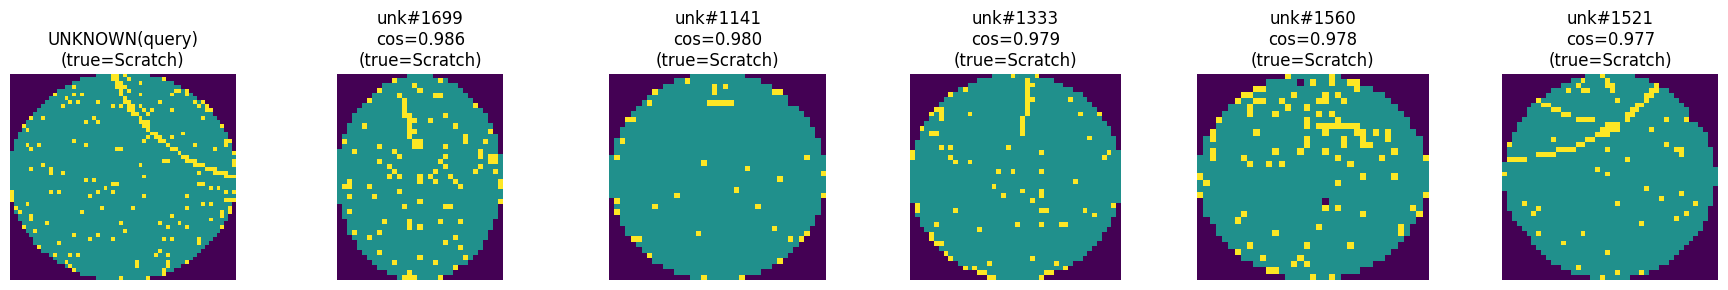

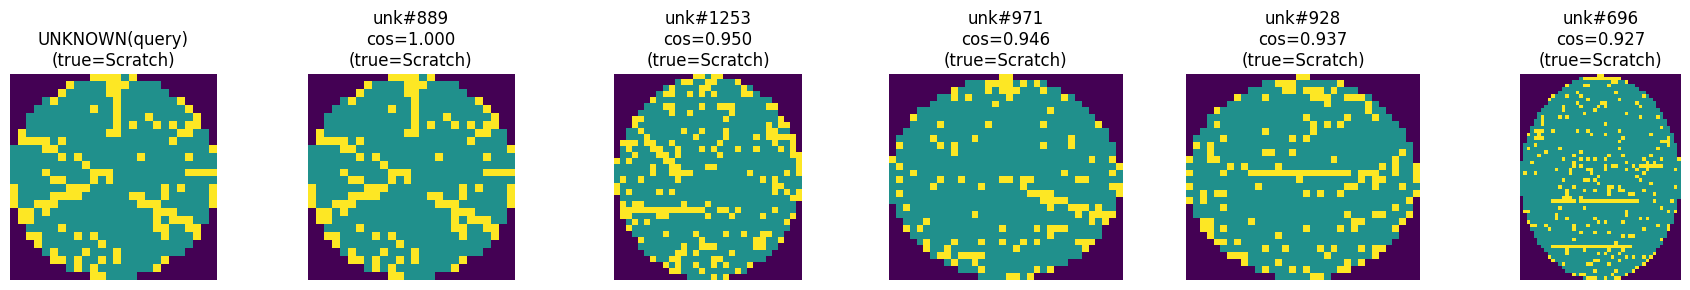

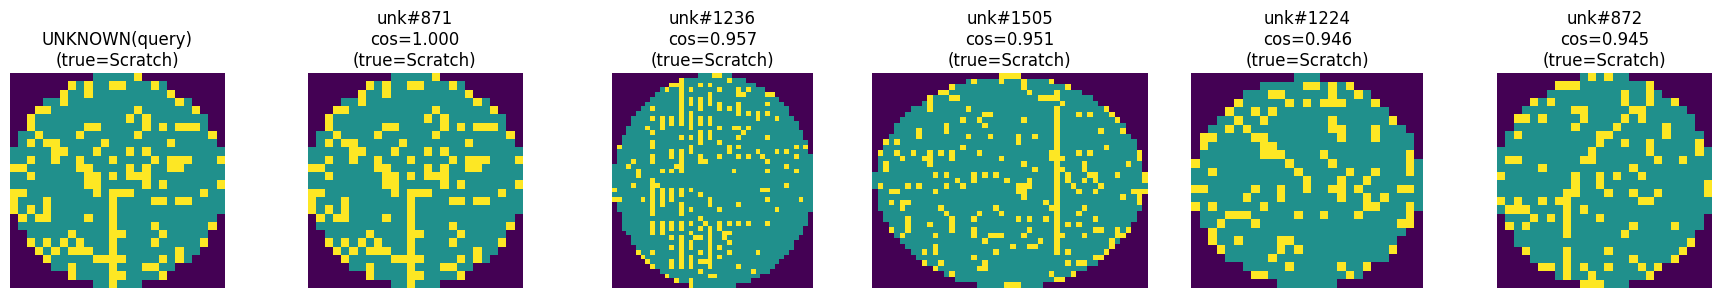

In [11]:
def show_unknown_neighbors(unk_i, K_show=5, show_true_label=True):
    # 첫 번째 이웃은 자기 자신일 가능성이 큼 -> 제외
    neigh = idx[unk_i]
    neigh_sim = sim[unk_i]

    # self 제외(동일 인덱스)
    pairs = [(j, s) for j, s in zip(neigh, neigh_sim) if j != unk_i]
    pairs = pairs[:K_show]

    plt.figure(figsize=(3*(K_show+1), 3))
    row = test_unknown_df.iloc[unk_i]
    plt.subplot(1, K_show+1, 1)
    plt.imshow(row["waferMap"])
    title = "UNKNOWN(query)"
    if show_true_label and "label" in row:
        title += f"\n(true={row['label']})"
    plt.title(title)
    plt.axis("off")

    for t, (j, s) in enumerate(pairs):
        r = test_unknown_df.iloc[int(j)]
        plt.subplot(1, K_show+1, t+2)
        plt.imshow(r["waferMap"])
        title = f"unk#{int(j)}\ncos={float(s):.3f}"
        if show_true_label and "label" in r:
            title += f"\n(true={r['label']})"
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 예시
for i in [0, 1, 2]:
    show_unknown_neighbors(i, K_show=5, show_true_label=True)


#### 10.15.3 unknown 클러스터링 (DBSCAN: “비슷한 애들끼리 자동 그룹핑”)

KMeans는 “군집 개수 K를 미리 정해야” 해서 MVP-2에는 덜 직관적이고,  
DBSCAN은 “밀도 기반”이라 신규 패턴 후보군 만들 때 스토리가 좋음.

In [12]:
from sklearn.cluster import DBSCAN
from collections import Counter

# cosine distance 기준 eps는 데이터마다 달라서 0.15~0.35 정도를 먼저 시도
eps = 0.25
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
unk_cluster = db.fit_predict(unk_n)  # -1은 noise(어느 군집에도 안 들어감)

cnt = Counter(unk_cluster)
print("cluster counts:", cnt)
print("num clusters (excluding -1):", len([k for k in cnt.keys() if k != -1]))

cluster counts: Counter({np.int64(0): 1748})
num clusters (excluding -1): 1


eps를 3개만 빠르게 스윕해서 “너무 다 -1”인지 확인

In [13]:
for eps_try in [0.20, 0.25, 0.30]:
    db = DBSCAN(eps=eps_try, min_samples=min_samples, metric="cosine")
    cl = db.fit_predict(unk_n)
    c = Counter(cl)
    ncl = len([k for k in c.keys() if k != -1])
    print(f"eps={eps_try:.2f} | clusters={ncl} | noise={c.get(-1,0)} / {len(cl)}")

eps=0.20 | clusters=1 | noise=3 / 1748
eps=0.25 | clusters=1 | noise=0 / 1748
eps=0.30 | clusters=1 | noise=0 / 1748


#### 10.15.4 군집별 대표 샘플 + 유사 샘플 저장(포스터/슬라이드 바로 사용)

군집 대표(centroid에 가장 가까운 샘플) 찾기

In [14]:
import numpy as np

def cluster_representatives(emb, cluster_ids):
    reps = {}
    for cid in sorted(set(cluster_ids)):
        if cid == -1:
            continue
        members = np.where(cluster_ids == cid)[0]
        if len(members) == 0:
            continue
        # centroid
        c = emb[members].mean(axis=0, keepdims=True)
        c = l2norm(c)[0]
        # centroid와 cosine similarity 최대인 샘플
        sims = emb[members] @ c
        rep = members[np.argmax(sims)]
        reps[cid] = int(rep)
    return reps

reps = cluster_representatives(unk_n, unk_cluster)
print("representatives:", reps)

representatives: {np.int64(0): 269}


군집 대표 + 같은 군집 Top-K 이웃을 한 장으로 저장

In [15]:
OUT_DIR = "assets/triage_unknown"
os.makedirs(OUT_DIR, exist_ok=True)

def save_cluster_panel(cid, rep_i, K_show=5, show_true_label=True):
    # rep_i의 이웃 중 같은 군집만 추림
    neigh = idx[rep_i]
    neigh_sim = sim[rep_i]
    pairs = []
    for j, s in zip(neigh, neigh_sim):
        j = int(j)
        if j == rep_i:
            continue
        if unk_cluster[j] == cid:
            pairs.append((j, float(s)))
        if len(pairs) >= K_show:
            break

    plt.figure(figsize=(3*(K_show+1), 3))
    rep_row = test_unknown_df.iloc[rep_i]
    plt.subplot(1, K_show+1, 1)
    plt.imshow(rep_row["waferMap"])
    title = f"cluster {cid}\nrep unk#{rep_i}"
    if show_true_label and "label" in rep_row:
        title += f"\n(true={rep_row['label']})"
    plt.title(title)
    plt.axis("off")

    for t, (j, s) in enumerate(pairs):
        r = test_unknown_df.iloc[j]
        plt.subplot(1, K_show+1, t+2)
        plt.imshow(r["waferMap"])
        title = f"unk#{j}\ncos={s:.3f}"
        if show_true_label and "label" in r:
            title += f"\n(true={r['label']})"
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    path = os.path.join(OUT_DIR, f"unknown_cluster{cid}_rep{rep_i}.png")
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    return path

saved = []
for cid, rep_i in list(reps.items())[:8]:  # 최대 8개 군집만 저장(조절 가능)
    saved.append(save_cluster_panel(cid, rep_i, K_show=5, show_true_label=True))

print("saved:", len(saved), "files in", OUT_DIR)

saved: 1 files in assets/triage_unknown


요약 CSV 저장 (군집 크기/대표/라벨 분포)

In [16]:
import pandas as pd
from collections import Counter

rows = []
for cid in sorted(set(unk_cluster)):
    members = np.where(unk_cluster == cid)[0]
    if len(members) == 0:
        continue
    row = {"cluster_id": int(cid), "count": int(len(members))}
    if cid != -1 and cid in reps:
        row["rep_unk_i"] = reps[cid]
    # 개발 중에는 true label 분포도 같이 기록(최종 데모에선 숨겨도 됨)
    if "label" in test_unknown_df.columns:
        labels = test_unknown_df.iloc[members]["label"].tolist()
        row["label_dist"] = dict(Counter(labels))
    rows.append(row)

df_cl = pd.DataFrame(rows).sort_values(["cluster_id"])
csv_path = os.path.join(OUT_DIR, "unknown_clusters_summary.csv")
df_cl.to_csv(csv_path, index=False, encoding="utf-8-sig")
csv_path, df_cl.head()

('assets/triage_unknown/unknown_clusters_summary.csv',
    cluster_id  count  rep_unk_i                       label_dist
 0           0   1748        269  {'Scratch': 1193, 'Donut': 555})